In [1]:
import torch
from transformers import BertTokenizer, BertModel
import numpy as np

In [2]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [3]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

    # Normalize embedding to [0, 1]
    min_val = embedding.min()
    max_val = embedding.max()
    normalized_embedding = (embedding - min_val) / (max_val - min_val)
    return normalized_embedding


In [4]:
# Read the triples from the file
with open('triples.txt', 'r') as file:
    lines = file.readlines()
l = lines[0].strip()

import ast
triples_data = ast.literal_eval(l)

output_file = 'triples_output.txt'
with open(output_file, 'w') as file:
    file.write("head,relation,tail\n")  # Write header line
    for triple in triples_data:
        file.write(f"{triple[0]},{triple[1]},{triple[2]}\n")

print(f"Triples data has been written to '{output_file}'.")


Triples data has been written to 'triples_output.txt'.


In [5]:
with open('triples_output.txt', 'r') as file:
    lines = file.readlines()[1:]  # Skip the header
triples = [line.strip().split(',') for line in lines]


In [6]:
triples

[['salt tolerance', 'Jasmonate ( JA ) signaling', 'inhibits'],
 ['HvOPR2', 'opda reductase3', 'activates'],
 ['OPR3', 'CK', 'inhibits'],
 ['grape genotypes', 'AGC kinase', 'interacts'],
 ['opda reductase3', 'AGC kinase', 'interacts'],
 ['free salicylic acid', 'AGC kinase', 'interacts'],
 ['rice', 'AGC kinase', 'interacts'],
 ['WSNLKKVILLKRFVKSL', 'BAP', 'inhibits'],
 ['LOC_Os09g02650', 'fatty acids', 'activates'],
 ['LOC_Os09g02650', 'GUS', 'activates'],
 ['LOC_Os09g02650', 'GID1 molecule', 'activates'],
 ['LOC_Os09g02650', 'AaGSW1', 'activates'],
 ['fatty acids', 'AaMYC2/AabZIP1', 'is-in'],
 ['GUS', 'AaMYC2/AabZIP1', 'is-in'],
 ['GID1 molecule', 'AaMYC2/AabZIP1', 'is-in'],
 ['AaGSW1', 'AaMYC2/AabZIP1', 'is-in'],
 ['LOC_Os09g02650', 'caterpillars', 'activates'],
 ['LOC_Os09g02650', 'JA', 'activates'],
 ['LOC_Os09g02650', '', '', 'activates'],
 ['growth and', 'rice', 'interacts'],
 ['growth and', 'induce', 'interacts'],
 ['barley', '2-hydroxyethyl jasmonate', 'inhibits'],
 ['grapevine',

In [8]:
# Extract unique entities and relations
entities = set()
relations = set()
for triple in triples:
    entities.add(triple[0])
    entities.add(triple[1])
    relations.add(triple[2])


In [9]:
unique_entities = list(entities)
unique_relations = list(relations)

In [10]:
# Generate embeddings for entities and relations
entity_embeddings = {}
for entity in unique_entities:
    with torch.no_grad():
        embedding = get_bert_embedding(entity)
        entity_embeddings[entity] = embedding


In [11]:
relation_embeddings = {relation: get_bert_embedding(relation) for relation in unique_relations}

In [12]:
def get_triple_embedding(triple):
    s, r, o = triple[0],triple[2], triple[1]
    s_emb = entity_embeddings[s]
    r_emb = relation_embeddings[r]
    o_emb = entity_embeddings[o]
    return np.concatenate([s_emb, r_emb, o_emb])

In [ ]:
# Print or save the embeddings
# for entity, embedding in entity_embeddings.items():
#     print(f"Entity: {entity}\nEmbedding: {embedding}\n")

In [13]:
triple_embeddings = []
for triple in triples:
    triple_emb = get_triple_embedding(triple)
    triple_embeddings.append(triple_emb)

triple_embeddings = np.array(triple_embeddings)

# Save embeddings to file
np.save('entity_embeddings.npy', triple_embeddings)

In [14]:
# Print the shape of triple_embeddings to understand its dimensions
print("Shape of triple_embeddings:", triple_embeddings.shape)

# Print the first few embeddings for illustration
num_to_print = min(5, len(triples))  # Print up to 5 embeddings or less if there are fewer triples
for i in range(num_to_print):
    print(f"Embedding for triple {i + 1}:")
    print(triple_embeddings[i])
    print()  # Add a newline for separation


Shape of triple_embeddings: (1405, 2304)
Embedding for triple 1:
[0.6491707  0.72645545 0.55904657 ... 0.8110414  0.79012287 0.8104254 ]

Embedding for triple 2:
[0.7378919  0.74440724 0.75266415 ... 0.5740817  0.53134406 0.69529396]

Embedding for triple 3:
[0.7041363  0.6893827  0.72752136 ... 0.7661218  0.6844027  0.75747305]

Embedding for triple 4:
[0.7667789  0.76395214 0.5957369  ... 0.68681496 0.7062252  0.76480085]

Embedding for triple 5:
[0.46071932 0.5106732  0.58006513 ... 0.68681496 0.7062252  0.76480085]



In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [16]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        return torch.sigmoid(self.fc2(h))

In [17]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [18]:
def loss_function(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [19]:
# Load embeddings from file
triple_embeddings = np.load('entity_embeddings.npy')
triple_tensor = torch.tensor(triple_embeddings, dtype=torch.float32)

# Define the VAE
vae = VAE(input_dim=triple_embeddings.shape[1], hidden_dim=512, latent_dim=256)
optimizer = optim.Adam(vae.parameters(), lr=1e-4)

In [20]:
# Train the VAE
num_epochs = 1000
for epoch in range(num_epochs):
    vae.train()
    optimizer.zero_grad()
    recon_batch, mu, logvar = vae(triple_tensor)
    loss = loss_function(recon_batch, triple_tensor, mu, logvar)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Save the model
torch.save(vae.state_dict(), 'vae_model.pth')

Epoch 0, Loss: 201403.28125
Epoch 10, Loss: 155071.8125
Epoch 20, Loss: 123299.5390625
Epoch 30, Loss: 94361.8515625
Epoch 40, Loss: 69619.2890625
Epoch 50, Loss: 54029.8984375
Epoch 60, Loss: 45710.69140625
Epoch 70, Loss: 41754.62109375
Epoch 80, Loss: 39211.12890625
Epoch 90, Loss: 37356.75390625
Epoch 100, Loss: 36797.51171875
Epoch 110, Loss: 36132.37890625
Epoch 120, Loss: 35383.83203125
Epoch 130, Loss: 34654.42578125
Epoch 140, Loss: 34455.3828125
Epoch 150, Loss: 33796.91015625
Epoch 160, Loss: 34016.3203125
Epoch 170, Loss: 33215.08984375
Epoch 180, Loss: 32857.734375
Epoch 190, Loss: 32752.7421875
Epoch 200, Loss: 32586.19921875
Epoch 210, Loss: 31828.95703125
Epoch 220, Loss: 31715.791015625
Epoch 230, Loss: 31412.05859375
Epoch 240, Loss: 31055.603515625
Epoch 250, Loss: 30791.50390625
Epoch 260, Loss: 30371.267578125
Epoch 270, Loss: 30222.025390625
Epoch 280, Loss: 30058.33203125
Epoch 290, Loss: 29758.193359375
Epoch 300, Loss: 29375.404296875
Epoch 310, Loss: 29289.421

In [21]:
# Generate latent embeddings
vae.eval()
with torch.no_grad():
    # Assuming batch size 1 for simplicity
    latent_embeddings = []
    for i in range(len(triple_tensor)):
        mu, _ = vae.encoder(triple_tensor[i:i+1])
        latent_embeddings.append(mu.numpy())

    latent_embeddings = np.array(latent_embeddings)
    print("Shape of latent embeddings:", latent_embeddings.shape)

# Save latent embeddings
np.save('latent_entity_embeddings.npy', latent_embeddings)

Shape of latent embeddings: (1405, 1, 256)


In [22]:
latent_embeddings = np.load('latent_entity_embeddings.npy')

# Print the shape of the embeddings to get an idea of the structure
print("Shape of latent embeddings:", latent_embeddings.shape)

# Load the triples to map entities to their embeddings
with open('triples_output.txt', 'r') as file:
    lines = file.readlines()

triples = []
for line in lines:
    parts = line.strip().split(',')
    if len(parts) >= 3:
        triples.append((parts[0].strip(), parts[1].strip(), parts[2].strip()))
    else:
        print(f"Skipping malformed line: {line}")

# Extract unique entities
entities = set()
for s, r, o in triples:
    entities.add(s)
    entities.add(o)

entities = list(entities)

# Create a dictionary mapping entities to their embeddings
entity_embeddings = {entity: latent_embeddings[i] for i, entity in enumerate(entities)}

# Print embeddings for a few entities
for entity, embedding in list(entity_embeddings.items())[:10]:
    print(f"Entity: {entity}")
    print(f"Embedding: {embedding}\n")

Shape of latent embeddings: (1405, 1, 256)
Entity: 
Embedding: [[ 0.08370814 -0.09100965 -0.03824256 -0.07204799  0.01082833 -0.0528658
   0.04377986 -0.15824021  0.07379955  0.19372149  0.09996328 -0.03306633
  -0.19138408  0.04201906 -0.12964734 -0.05167787  0.10852277 -0.10567538
  -0.16661666  0.10635146  0.1055733   0.15352076 -0.05840077  0.11714561
   0.14135137 -0.09905702 -0.06885353  0.1501422   0.03643486 -0.11818636
   0.10443078  0.07511078 -0.05899135  0.08575255 -0.13478774 -0.05427665
   0.01571567  0.07705746 -0.01436603 -0.01669582 -0.06796416  0.12514694
  -0.13102013  0.10580988  0.16212347 -0.11600091  0.03938855  0.02409508
  -0.08319964  0.02900796 -0.10849828  0.1513364  -0.09381813 -0.07513931
  -0.07936874  0.11495896  0.1732507   0.00255458 -0.08708629 -0.10930546
   0.14350316 -0.04221196  0.05151665  0.0786468  -0.11537224 -0.10995437
   0.14832954  0.0796787  -0.04163666  0.13186686 -0.14214571  0.11808945
   0.18393216 -0.15617356 -0.05392954 -0.10220044 

Shape of latent embeddings before reshaping: (1405, 1, 256)
Shape of latent embeddings after reshaping: (1405, 256)


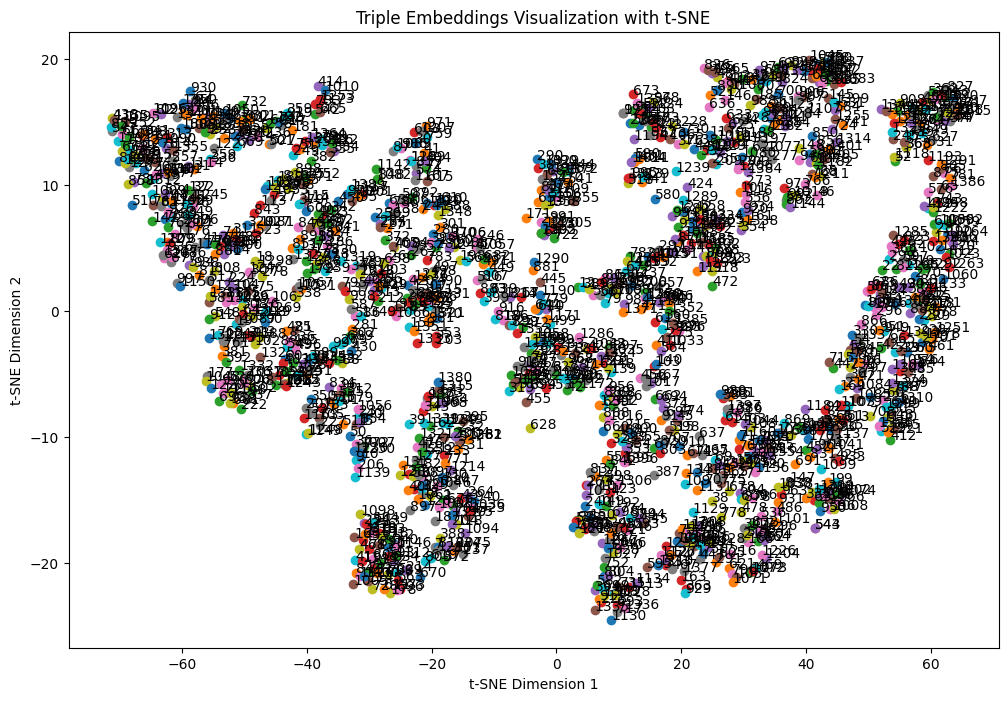

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Load latent embeddings
latent_embeddings = np.load('latent_entity_embeddings.npy')

# Check the shape of the embeddings to ensure correctness
print("Shape of latent embeddings before reshaping:", latent_embeddings.shape)

# Reshape latent embeddings to remove the extra dimension
latent_embeddings = latent_embeddings.reshape(latent_embeddings.shape[0], -1)

# Check the shape after reshaping
print("Shape of latent embeddings after reshaping:", latent_embeddings.shape)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(latent_embeddings)

# Load the triples to map entities to their embeddings
with open('triples_output.txt', 'r') as file:
    lines = file.readlines()[1:]  # Skip the header

triples = [line.strip().split(',') for line in lines]
entities = [triple[0] for triple in triples] + [triple[1] for triple in triples]
relations = [triple[2] for triple in triples]

# Plot the embeddings
plt.figure(figsize=(12, 8))
for i, (x, y) in enumerate(reduced_embeddings):
    plt.scatter(x, y)
    plt.text(x, y, str(i))  # Label each point with its index for simplicity

plt.title('Triple Embeddings Visualization with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


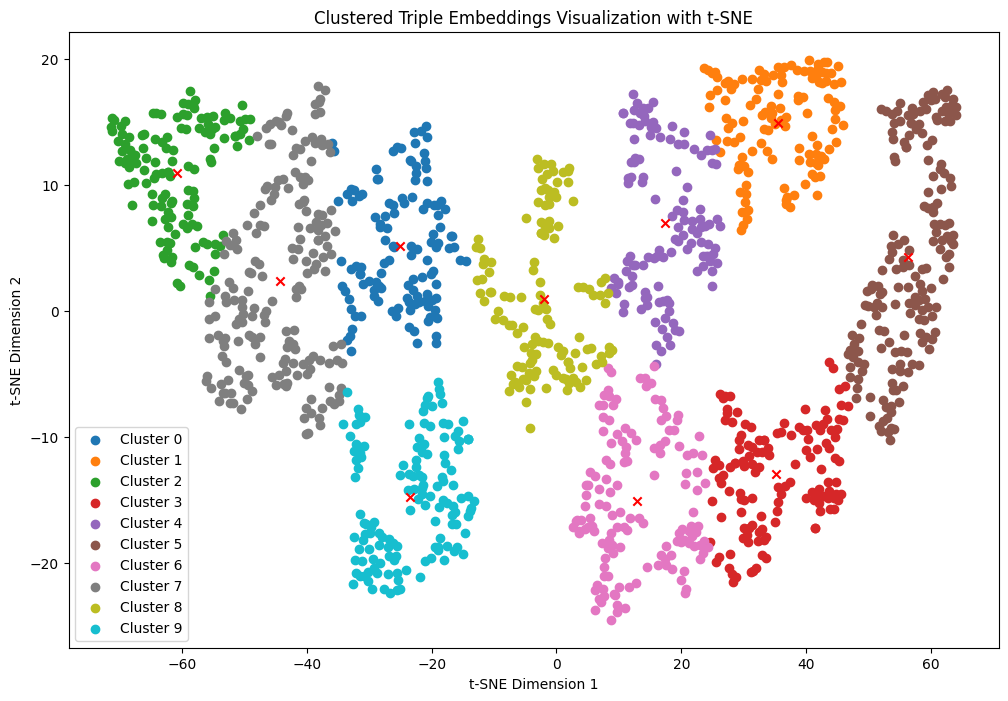

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Load latent embeddings
latent_embeddings = np.load('latent_entity_embeddings.npy')

# Reshape latent embeddings to remove the extra dimension
latent_embeddings = latent_embeddings.reshape(latent_embeddings.shape[0], -1)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(latent_embeddings)

# Load the triples to map entities to their embeddings
with open('triples_output.txt', 'r') as file:
    lines = file.readlines()[1:]  # Skip the header

triples = [line.strip().split(',') for line in lines]
entities = [triple[0] for triple in triples] + [triple[2] for triple in triples]
relations = [triple[1] for triple in triples]

# Cluster the embeddings
num_clusters = 10  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Plot the cluster centroids and the embeddings
plt.figure(figsize=(12, 8))
for i in range(num_clusters):
    cluster_points = reduced_embeddings[clusters == i]
    centroid = kmeans.cluster_centers_[i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i}')
    plt.scatter(centroid[0], centroid[1], c='red', marker='x')

plt.title('Clustered Triple Embeddings Visualization with t-SNE')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()
